In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_wc_ranked = pd.pandas('WC_Ranked_Results_Fifa_Merged.xlsx')

# Feature Engineering

Seperate Home & Away Teams, Get Statistical Values, Label, then Merge
 
### Features that impact could be:

* Past game points made
* Past goals scored and suffered
* The importance of game (friendly or not)
* Rank of the teams (difference of ranks)
* Rank increasement of the teams
* Goals made and suffered by ranking faced

In [ ]:
# Game Points (Different than the FIFA rank points that are already in the database):
# 3 for win
# 1 for draw
# 0 for lose

def highest_score(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df_wc_ranked.apply(lambda x: highest_score(x["home_score"], x["away_score"]), axis=1)
df_wc_ranked[["result", "home_team_points", "away_team_points"]] = results

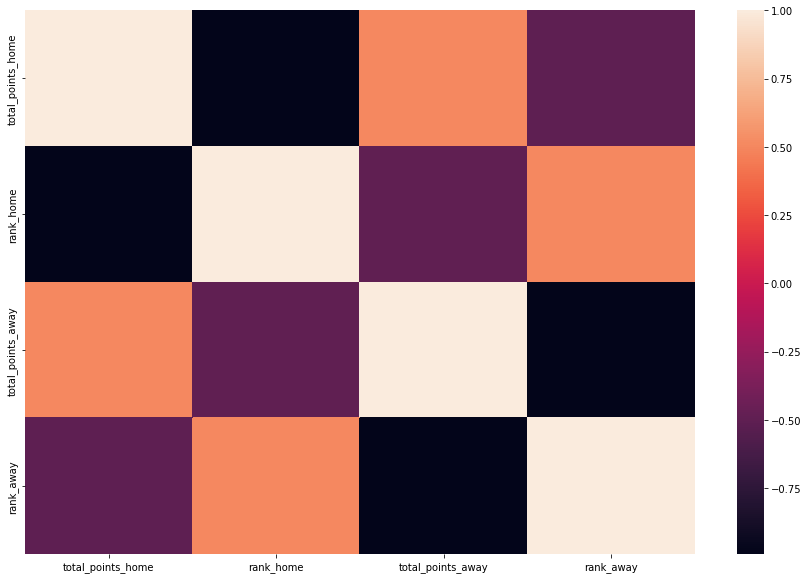

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_wc_ranked[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

Ranking Diffference between match home and away


In [ ]:
df_wc_ranked["rank_dif"] = df_wc_ranked["rank_home"] - df_wc_ranked["rank_away"]

Points won at the game vs. team faced rank 
(home or away points) / (rank away or rank home)

In [ ]:
df_wc_ranked["points_home_by_rank"] = df_wc_ranked["home_team_points"]/df_wc_ranked["rank_away"]
df_wc_ranked["points_away_by_rank"] = df_wc_ranked["away_team_points"]/df_wc_ranked["rank_home"]

Goals difference in the game

In [ ]:
df_wc_ranked["goals_difference"] = df_wc_ranked["home_score"] - df_wc_ranked["away_score"]

### Seperate Dataset into Home & Away team 

In [ ]:
df_wc_ranked.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'points_home_by_rank', 'points_away_by_rank',
       'goals_difference'],
      dtype='object')

In [ ]:
home_team = df_wc_ranked[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team = df_wc_ranked[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]
away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

team_stats = home_team.append(away_team)#.sort_values("date")
team_stats_raw = team_stats.copy() # feature calculation for simulation
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2018-08-18,Andorra,0.0,0.0,130.0,77.0,0.0,1120.00,2,53.0,0.012987,1
1,2018-08-18,Grenada,1.0,5.0,168.0,54.0,0.0,980.00,1,114.0,0.000000,0
2,2018-08-18,Guatemala,1.0,0.0,146.0,181.0,0.0,1064.00,0,-35.0,0.016575,3
3,2018-08-20,Barbados,2.0,2.0,160.0,54.0,0.0,1005.00,2,106.0,0.018519,1
4,2018-08-26,Barbados,0.0,0.0,160.0,181.0,0.0,1005.00,2,-21.0,0.005525,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3331,2022-09-27,Serbia,2.0,0.0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3
3332,2022-09-27,Slovenia,1.0,1.0,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1
3333,2022-09-27,Cyprus,1.0,5.0,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0
3334,2022-09-27,Northern Ireland,1.0,3.0,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0


### Predictive features:
* Mean goals of the team in World Cup Cycle.
* Mean goals of the team in last 5 games.
* Mean goals suffered of the team in World Cup Cycle.
* Mean goals suffered of the team in last 5 games.
* Mean game points at the Cycle.
* Mean game points at last 5 games.
* Mean game points by rank faced at the Cycle.
* Mean game points by rank faced at last 5 games.
* Mean FIFA Rank that team faced in World Cup Cycle.
* Mean FIFA Rank that team faced in last 5 games.
* FIFA Points won at the cycle.
* FIFA Points won in last 5 games.

In [ ]:
stat_columns = ["mean_score", "mean_score_past15", "mean_score_suf", "mean_score_suf_past15", "mean_rank", "mean_rank_past15", "mean_points", "mean_points_past15", "mean_game_points", "mean_game_points_past15", "mean_game_points_rank", "mean_game_points_rank_past15"]
stat_values = []

for index, row in team_stats.iterrows():
    # Last 5 games 
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    # Goals
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    # Goals Suffered
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    # Rank
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0

    # Team Points    
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    # Points by rank
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    stat_values.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

Merge Matches

In [ ]:
df_stat_values = pd.DataFrame(stat_values, columns=stat_columns)

full_df = pd.concat([team_stats.reset_index(drop=True), df_stat_values], axis=1, ignore_index=False)

home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]

away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
full_df = pd.concat([df_wc_ranked, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

Filter Matches Type

In [ ]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 
full_df = pd.get_dummies(full_df, columns=["is_friendly"])



Remove Following Features From Base Dataframe 

[ tournament, city, country, neutral, total_points_home, previous_points_home, total_points_away, previous_points_away, home_team_points, away_team_points, points_home_by_rank, points_away_by_rank, goals_difference ]


In [ ]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_mean_score',
       'home_mean_score_past15', 'home_mean_score_suf', 'home_mean_score_suf_past15',
       'home_mean_rank', 'home_mean_rank_past15', 'home_mean_points',
       'home_mean_points_past15', 'away_mean_score', 'away_mean_score_past15',
       'away_mean_score_suf', 'away_mean_score_suf_past15', 'away_mean_rank',
       'away_mean_rank_past15', 'away_mean_points', 'away_mean_points_past15','home_mean_game_points', 'home_mean_game_points_past15',
       'home_mean_game_points_rank', 'home_mean_game_points_rank_past15','away_mean_game_points',
       'away_mean_game_points_past15', 'away_mean_game_points_rank',
       'away_mean_game_points_rank_past15',
       'is_friendly_0', 'is_friendly_1']]

print(base_df.isna().sum())
base_df_no_na = base_df.dropna()

date                                   0
home_team                              0
away_team                              0
rank_home                              0
rank_away                              0
home_score                             0
away_score                             0
result                                 0
rank_dif                               0
rank_change_home                       0
rank_change_away                       0
home_mean_score                      101
home_mean_score_past15               101
home_mean_score_suf                  101
home_mean_score_suf_past15           101
home_mean_rank                       101
home_mean_rank_past15                101
home_mean_points                       0
home_mean_points_past15                0
away_mean_score                      100
away_mean_score_past15               100
away_mean_score_suf                  100
away_mean_score_suf_past15           100
away_mean_rank                       100
away_mean_rank_p

# Data Analysis

Check Created Features Whether They Can Be Used For Prediction

### Created Features:

* Score Difference
* Score Difference Suffered
* Score Difference Past 5 Matches
* Score Difference Suffered Past 5 Matches
* Points Difference
* Points Difference Suffered
* Points Difference Past 5 Matches
* Points Difference Suffered Past 5 Matches
* Rank Difference
* Rank Difference Suffered
* Rank Difference Past 5 Matches
* Rank Difference Suffered Past 5 Matches


Assign Draw Matches As Lose Of Home

In [ ]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
base_df_no_na["target"] = base_df_no_na["result"].apply(lambda x: no_draw(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Analyze different distribution to target using violin and boxplot:

* Which Variable Can Be Used to determine performance (i.e. Comparision of Home & Away)?

In [ ]:
data1 = base_df_no_na[list(base_df_no_na.columns[8:20].values) + ["target"]]
data2 = base_df_no_na[base_df_no_na.columns[20:]]
print(data1.columns)
print(data2.columns)

Index(['rank_dif', 'rank_change_home', 'rank_change_away', 'home_mean_score',
       'home_mean_score_past15', 'home_mean_score_suf',
       'home_mean_score_suf_past15', 'home_mean_rank', 'home_mean_rank_past15',
       'home_mean_points', 'home_mean_points_past15', 'away_mean_score',
       'target'],
      dtype='object')
Index(['away_mean_score_past15', 'away_mean_score_suf',
       'away_mean_score_suf_past15', 'away_mean_rank', 'away_mean_rank_past15',
       'away_mean_points', 'away_mean_points_past15', 'home_mean_game_points',
       'home_mean_game_points_past15', 'home_mean_game_points_rank',
       'home_mean_game_points_rank_past15', 'away_mean_game_points',
       'away_mean_game_points_past15', 'away_mean_game_points_rank',
       'away_mean_game_points_rank_past15', 'is_friendly_0', 'is_friendly_1',
       'target'],
      dtype='object')


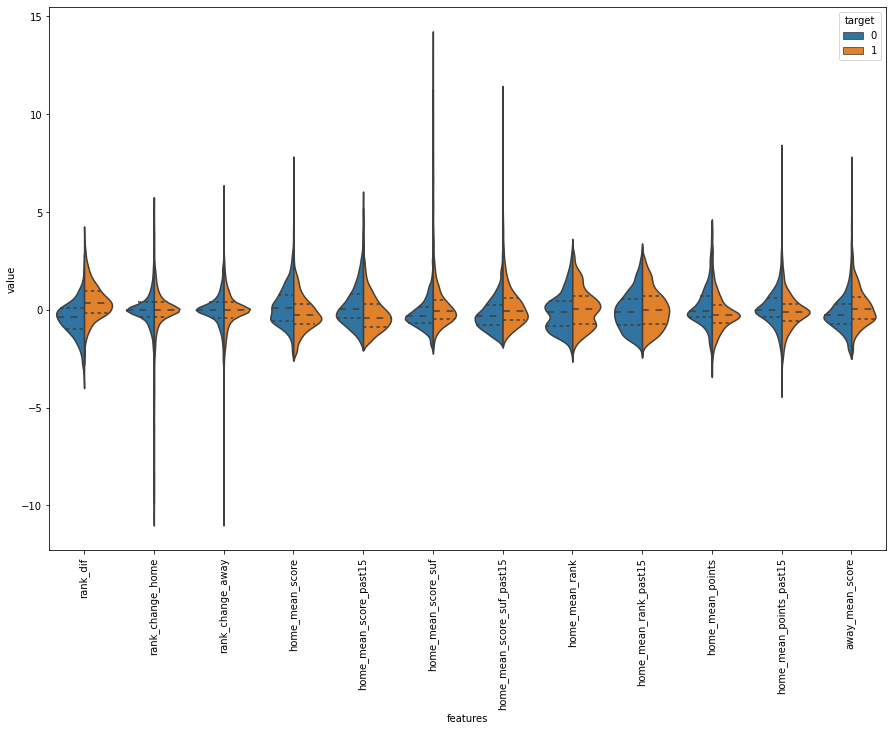

In [ ]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

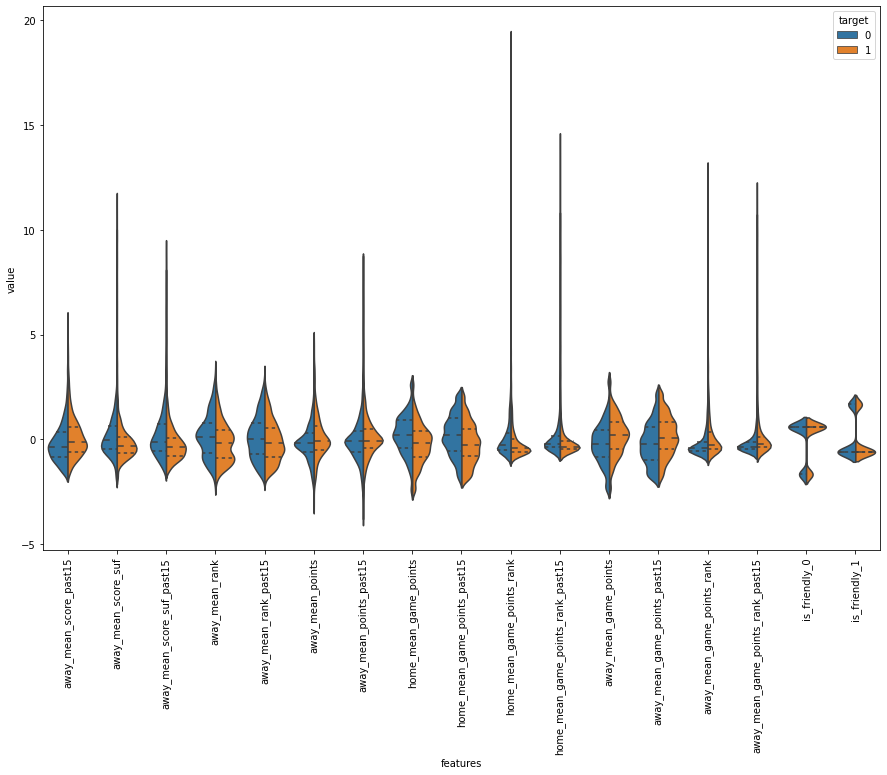

In [ ]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Team's Score Difference (Away & Home) For Performance Comparision

***Score Selected Features:***

* home_mean_score
* home_mean_score_past15
* home_mean_score_suf
* home_mean_score_suf_past15
* away_mean_score
* away_mean_score_past15
* away_mean_score_suf
* away_mean_score_suf_past15

***Score Calculated differences:***
* Score Difference Home and Away
* Score Difference Home and Away Past 5 Matches
* Score Difference Home Suffered and Away Suffered
* Score Difference Home Suffered and Away Suffered Past 5 Matches
* Score Difference Home and Away Suffered
* Score Difference Home and Away Suffered Past 5 Matches
* Score Difference Home Suffered and Away
* Score Difference Home Suffered and Away Past 5 Matches

In [ ]:
dif = base_df_no_na.copy()
dif.loc[:, "score_diff"] = dif["home_mean_score"] - dif["away_mean_score"]
dif.loc[:, "score_diff_past5"] = dif["home_mean_score_past15"] - dif["away_mean_score_past15"]
dif.loc[:, "score_suf_diff"] = dif["home_mean_score_suf"] - dif["away_mean_score_suf"]
dif.loc[:, "score_suf_diff_past5"] = dif["home_mean_score_suf_past15"] - dif["away_mean_score_suf_past15"]
dif.loc[:, "score_made_away_suf_diff"] = dif["home_mean_score"] - dif["away_mean_score_suf"]
dif.loc[:, "score_made_away_suf_diff_past5"] = dif["home_mean_score_past15"] - dif["away_mean_score_suf_past15"]
dif.loc[:, "score_made_home_suf_diff"] = dif["home_mean_score_suf"] - dif["away_mean_score"]
dif.loc[:, "score_made_home_suf_diff_past5"] = dif["home_mean_score_suf_past15"] - dif["away_mean_score_past15"]

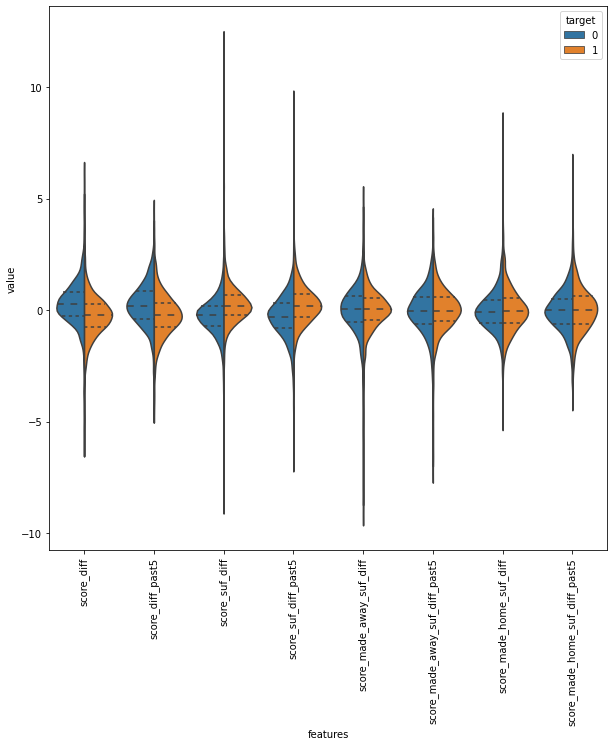

In [ ]:
data_diff = dif.iloc[:, -8:]
scaled = (data_diff - data_diff.mean()) / data_diff.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

***Points Selected Features:***

* away_mean_game_points_past15
* home_mean_game_points_past15
* home_mean_game_points
* away_mean_game_points
* home_mean_game_points_rank_past15
* away_mean_game_points_rank_past15
* home_mean_rank
* away_mean_rank
* home_mean_rank_past15
* away_mean_rank_past15

***Points Calculated differences:***
* Points Different
* Points different Past 5 Matches
* Points Different By Rank 
* Points Different By Rank Past 5 Matches
* Different Ranks Played Against 
* Different Ranks Played Against Past 5 Matches

In [ ]:
dif.loc[:, "points_diff"] = dif["home_mean_game_points"] - dif["away_mean_game_points"]
dif.loc[:, "points_diff_past5"] = dif["home_mean_game_points_past15"] - dif["away_mean_game_points_past15"]
dif.loc[:, "points_diff_rank"] = dif["home_mean_game_points_rank"] - dif["away_mean_game_points_rank"]
dif.loc[:, "points_diff_rank_past5"] = dif["home_mean_game_points_rank_past15"] - dif["away_mean_game_points_rank_past15"]
dif.loc[:, "diff_rank_against"] = dif["home_mean_rank"] - dif["away_mean_rank"]
dif.loc[:, "diff_rank_against_past5"] = dif["home_mean_rank_past15"] - dif["away_mean_rank_past15"]

In [ ]:
dif.columns

Index(['date', 'home_team', 'away_team', 'rank_home', 'rank_away',
       'home_score', 'away_score', 'result', 'rank_dif', 'rank_change_home',
       'rank_change_away', 'home_mean_score', 'home_mean_score_past15',
       'home_mean_score_suf', 'home_mean_score_suf_past15', 'home_mean_rank',
       'home_mean_rank_past15', 'home_mean_points', 'home_mean_points_past15',
       'away_mean_score', 'away_mean_score_past15', 'away_mean_score_suf',
       'away_mean_score_suf_past15', 'away_mean_rank', 'away_mean_rank_past15',
       'away_mean_points', 'away_mean_points_past15', 'home_mean_game_points',
       'home_mean_game_points_past15', 'home_mean_game_points_rank',
       'home_mean_game_points_rank_past15', 'away_mean_game_points',
       'away_mean_game_points_past15', 'away_mean_game_points_rank',
       'away_mean_game_points_rank_past15', 'is_friendly_0', 'is_friendly_1',
       'target', 'score_diff', 'score_diff_past5', 'score_suf_diff',
       'score_suf_diff_past5', 'score_m

* Differences of points made
* Differences of points made by rank faced
* Differences of rank faced

Features:
* away_mean_score
* home_mean_score
* away_mean_rank
* home_mean_rank
* home_mean_score_suf
* away_mean_score_suf
* home_mean_score_past15
* away_mean_score_past15

Calculated Features:
* Score Per Ranking Different
* Score Per Ranking Different Suffered

In [ ]:
dif.loc[:, "score_per_ranking_diff"] = (dif["home_mean_score"] / dif["home_mean_rank"]) - (dif["away_mean_score"] / dif["away_mean_rank"])
dif.loc[:, "score_per_ranking_suf_diff"] = (dif["home_mean_score_suf"] / dif["home_mean_rank"]) - (dif["away_mean_score_suf"] / dif["away_mean_rank"])
dif.loc[:, "score_per_ranking_diff_past5"] = (dif["home_mean_score_past15"] / dif["home_mean_rank"]) - (dif["away_mean_score_past15"] / dif["away_mean_rank"])
dif.loc[:, "score_per_ranking_suf_diff_past5"] = (dif["home_mean_score_suf_past15"] / dif["home_mean_rank"]) - (dif["away_mean_score_suf_past15"] / dif["away_mean_rank"])

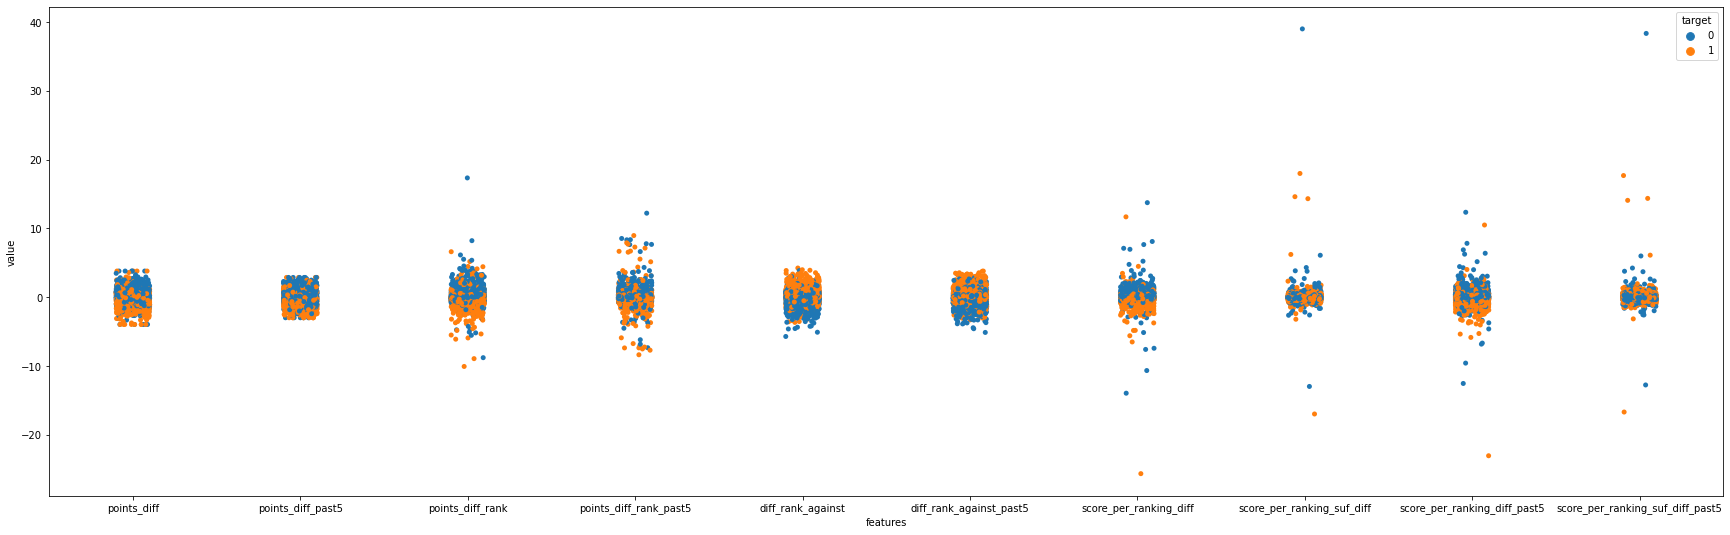

In [ ]:
data_diff = dif.iloc[:, -10:]
scaled = (data_diff - data_diff.mean()) / data_diff.std()
scaled["target"] = data2["target"]
data_diff = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")
fig, ax = plt.subplots(figsize=(30,9))
sns.stripplot(data = data_diff, x='features', y='value', hue="target", ax=ax)
plt.show()

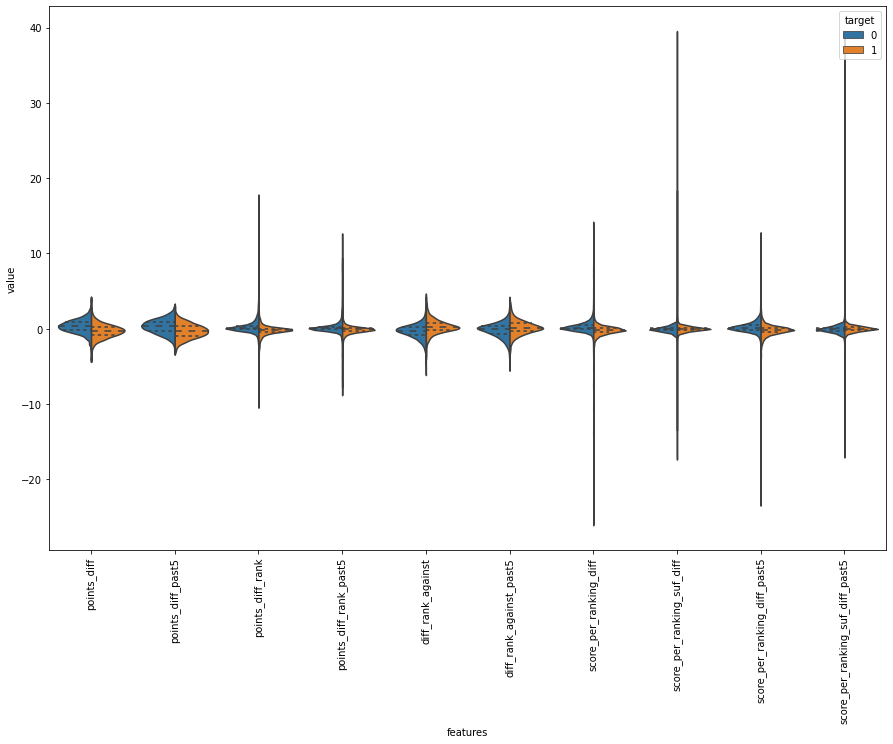

In [ ]:
data_diff = dif.iloc[:, -10:]
scaled = (data_diff - data_diff.mean()) / data_diff.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

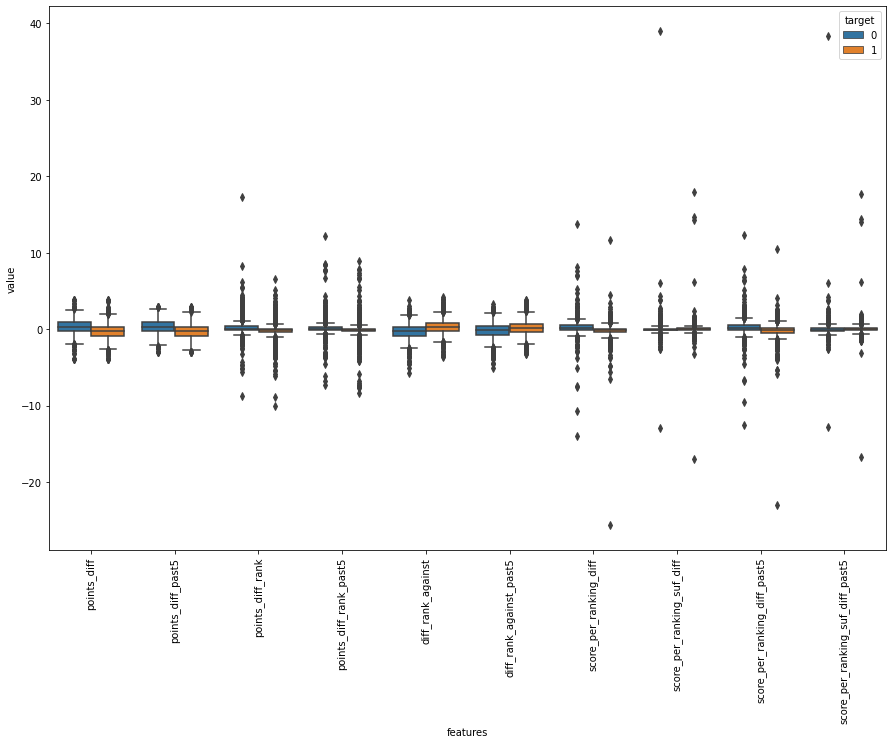

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

Analyze coorrelation using scatter plot

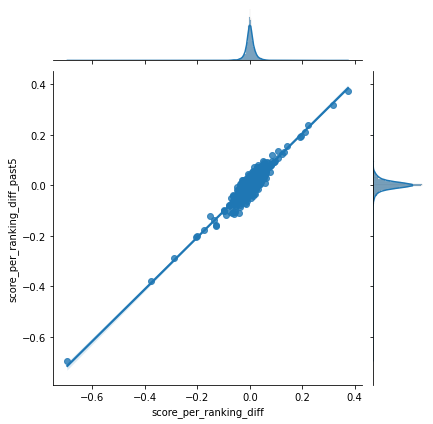

In [ ]:
sns.jointplot(data = data_diff, x = 'score_per_ranking_diff', y = 'score_per_ranking_diff_past5', kind="reg")
plt.show()

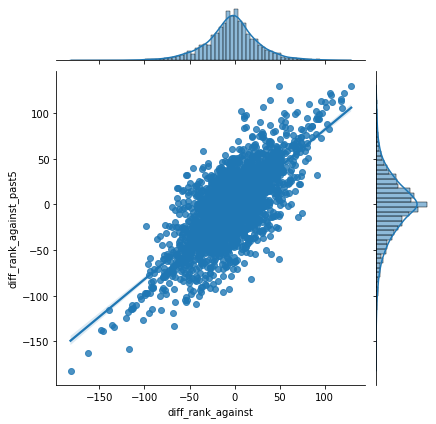

In [ ]:
sns.jointplot(data = data_diff, x = 'diff_rank_against', y = 'diff_rank_against_past5', kind="reg")
plt.show()

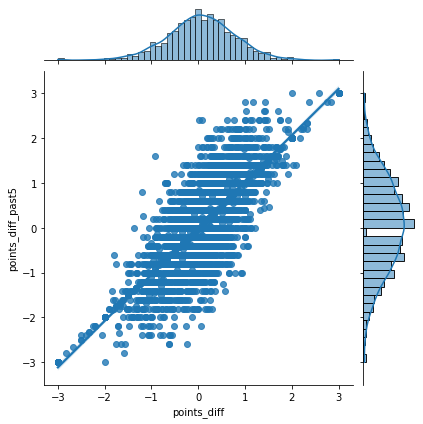

In [ ]:
sns.jointplot(data = data_diff, x = 'points_diff', y = 'points_diff_past5', kind="reg")
plt.show()

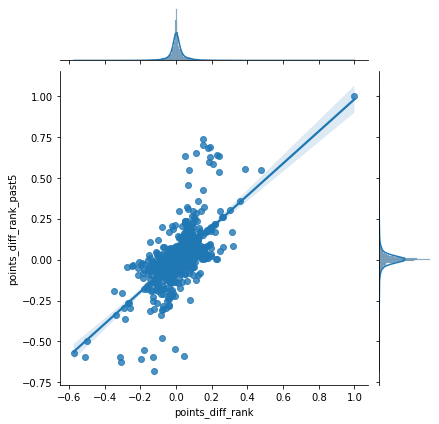

In [ ]:
sns.jointplot(data = data_diff, x = 'points_diff_rank', y = 'points_diff_rank_past5', kind="reg")
plt.show()

In [ ]:
columns = ["home_team", "away_team", "target", "rank_dif", "home_mean_score", "home_mean_rank", "away_mean_score", "away_mean_rank", "home_mean_rank_past15", "away_mean_rank_past15", "home_mean_score_suf", "away_mean_score_suf", "home_mean_score_past15", "away_mean_score_past15", "home_mean_score_suf_past15", "away_mean_score_suf_past15", "home_mean_game_points_rank", "home_mean_game_points_rank_past15", "away_mean_game_points_rank", "away_mean_game_points_rank_past15","is_friendly_0", "is_friendly_1"]
    
base = dif.loc[:, columns]
base.loc[:, "score_dif"] = base["home_mean_score"] - base["away_mean_score"]
base.loc[:, "score_dif_past5"] = base["home_mean_rank_past15"] - base["away_mean_rank_past15"]
base.loc[:, "score_suf_diff"] = base["home_mean_score_suf"] - base["away_mean_score_suf"]
base.loc[:, "score_suf_diff_past5"] = base["home_mean_score_suf_past15"] - base["away_mean_score_suf_past15"]
base.loc[:, "score_per_ranking_diff"] = (base["home_mean_score"] / base["home_mean_rank"]) - (base["away_mean_score"] / base["away_mean_rank"])
base.loc[:, "diff_rank_against"] = base["home_mean_rank"] - base["away_mean_rank"]
base.loc[:, "diff_rank_against_past5"] = base["home_mean_rank_past15"] - base["away_mean_rank_past15"]
base.loc[:, "points_diff_rank"] = base["home_mean_game_points_rank"] - base["away_mean_game_points_rank"]
base.loc[:, "points_diff_rank_past5"] = base["home_mean_game_points_rank_past15"] - base["away_mean_game_points_rank_past15"]

model_df = base[["home_team", "away_team", "target", "rank_dif", "score_dif", "score_dif_past5", "score_suf_diff", "score_suf_diff_past5", "score_per_ranking_diff", "diff_rank_against", "diff_rank_against_past5", "points_diff_rank", "points_diff_rank_past5", "is_friendly_0", "is_friendly_1"]]
model_df.to_excel('model_dataframe.xlsx')